# <center> TensorFlow and Deep Learning </center>

## Convolutional Neural Networks - CIFAR10

<br>

<center> ![](cifar10.png) </center>

*<p style="text-align:right">CIFAR10 - Adapted from Alex Krizhevsky at https://www.cs.toronto.edu/~kriz/cifar.html</p>*



In [1]:
import os
import numpy as np
import pickle
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
class CifarLoader(object):
    def __init__(self, source_files):
        self._source = source_files
        self._i = 0
        self.images = None
        self.labels = None
        
    def load(self):
        data = [unpickle(f) for f in self._source]
        images = np.vstack([d[b"data"] for d in data])
        n = len(images)
        self.images = images.reshape(n, 3, 32, 32).transpose(0, 2, 3, 1).astype(float)/255
        self.labels = one_hot(np.hstack([d[b"labels"] for d in data]), 10)
        return self
    
    def next_batch(self, batch_size):
        x, y = self.images[self._i:self._i+batch_size], self.labels[self._i:self._i+batch_size]
        self._i = (self._i + batch_size)%len(self.images)
        return x, y    

In [3]:
path = "cifar10"

def unpickle(file):
    with open(os.path.join(path,file), 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

def one_hot(vec, vals=10):
    n = len(vec)
    out = np.zeros((n, vals))
    out[range(n), vec] = 1
    return out

class CifarDataManager(object):
    def __init__(self):
        self.train = CifarLoader(["data_batch_{}".format(i) for i in range(1,6)]).load()
        self.test = CifarLoader(["test_batch"]).load()

Number of train images: 50000
Number of train labels: 50000
Number of test images: 10000
Number of test labels: 10000


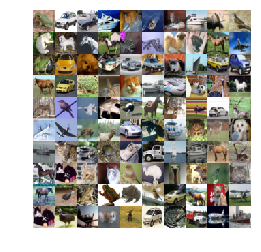

In [4]:
def display_cifar(images, size):
    n = len(images)
    plt.figure()
    plt.gca().set_axis_off()
    im = np.vstack([np.hstack([images[np.random.choice(n)] for i in range(size)]) for i in range(size)])
    plt.imshow(im)
    plt.show()
    
d = CifarDataManager()

print("Number of train images: {}".format(len(d.train.images)))
print("Number of train labels: {}".format(len(d.train.labels)))
print("Number of test images: {}".format(len(d.test.images)))
print("Number of test labels: {}".format(len(d.test.labels)))

images = d.train.images
display_cifar(images, 10)

In [5]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1,1,1,1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

def conv_layer(input, shape):
    W = weight_variable(shape)
    b = bias_variable([shape[3]])
    return tf.nn.relu(conv2d(input, W)+b)

def full_layer(input, size):
    in_size = int(input.get_shape()[1])
    W = weight_variable([in_size, size])
    b = bias_variable([size])
    return tf.matmul(input, W)+b 

In [6]:
cifar = CifarDataManager() 

x = tf.placeholder(tf.float32, shape=[None, 32, 32, 3]) 
y_ = tf.placeholder(tf.float32, shape=[None, 10]) 
keep_prob = tf.placeholder(tf.float32) 

conv1 = conv_layer(x, shape=[5, 5, 3, 32])
conv1_pool = max_pool_2x2(conv1) 

conv2 = conv_layer(conv1_pool, shape=[5, 5, 32, 64]) 
conv2_pool = max_pool_2x2(conv2) 
conv2_flat = tf.reshape(conv2_pool, [-1, 8 * 8 * 64]) 

full_1 = tf.nn.relu(full_layer(conv2_flat, 1024))
full1_drop = tf.nn.dropout(full_1, keep_prob=keep_prob) 

y_conv = full_layer(full1_drop, 10)

In [8]:
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_conv, labels=y_))
train_step = tf.train.AdamOptimizer(1e-3).minimize(cross_entropy) 
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

def test(sess):
    X = cifar.test.images.reshape(10,1000,32,32,3)
    Y = cifar.test.labels.reshape(10,1000,10)
    acc = np.mean([sess.run(accuracy,feed_dict={x:X[i], y_:Y[i], keep_prob:1.0}) for i in range(10)])
    print("Accuracy: {:.4}%".format(acc*100))
    
STEPS = 120
BATCH_SIZE = 100

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(STEPS):
        batch = cifar.train.next_batch(BATCH_SIZE)
        sess.run(train_step, feed_dict={x:batch[0], y_:batch[1], keep_prob:0.5})
        
    test(sess)

Accuracy: 41.01%
